# Universal differential equation for SIR ODE model

The script provided below is closely based on and inspired by the tutorial available at the following link: https://docs.sciml.ai/Overview/stable/showcase/missing_physics/

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1111);

### Define the SIR dynamics and solve the ODE

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ODE = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0);

In [3]:
prob = ODEProblem(sir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

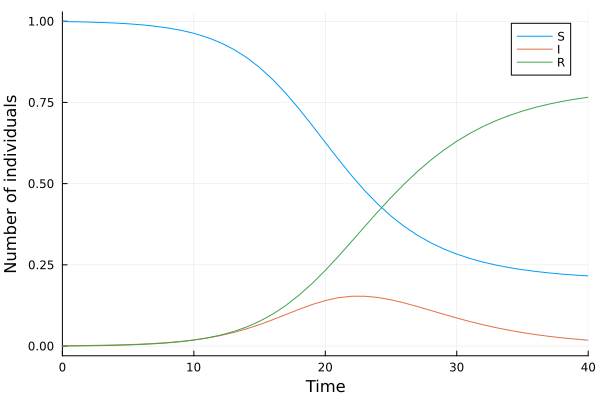

In [4]:
plot(sol, xlabel = "Time", ylabel = "Number of individuals", labels = ["S" "I" "R"])

### Add multiplicative log-normal noise

In [5]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.01)
noise = rand(rng, dist, size(X))
X_noisy = noise .* X;

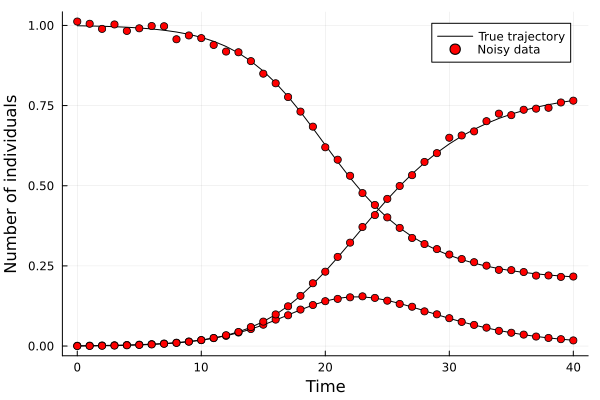

In [6]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals",
     color = :black, label=["True trajectory" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u)+\text{NN}(u)$.

In [7]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))   

# Multi-layer feed-forward neural network
model = Chain(Dense(2, 5, rbf), Dense(5, 5, rbf), Dense(5, 2))

# Get initial parameters and state variables of the model
p_init, st = Lux.setup(rng, model);

In [8]:
# Define the hybrid model
β, γ, N = p_ODE

function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u[1:2], p, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -γ*u[2] + nn[2] 
    du[3] = γ*u[2]
end

prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### Set up the training

In [9]:
function predict(p)   # p is the parameter of the NN and the ODE at the same time
    _prob = remake(prob_ude, p=p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = t,
                sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [10]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂)   # MSE loss
end;

In [11]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [22]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, p_init);   # without ComponentVector{Float64}()

In [23]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

LoadError: MethodError: no method matching copy(::NamedTuple{(:layer_1, :layer_2, :layer_3), Tuple{NamedTuple{(:weight, :bias), Tuple{Matrix{Float32}, Matrix{Float32}}}, NamedTuple{(:weight, :bias), Tuple{Matrix{Float32}, Matrix{Float32}}}, NamedTuple{(:weight, :bias), Tuple{Matrix{Float32}, Matrix{Float32}}}}})

[0mClosest candidates are:
[0m  copy([91m::Union{DiffEqNoiseProcess.BoxWedgeTail, DiffEqNoiseProcess.NoiseApproximation, DiffEqNoiseProcess.NoiseGrid, DiffEqNoiseProcess.NoiseWrapper, DiffEqNoiseProcess.VirtualBrownianTree}[39m)
[0m[90m   @[39m [32mDiffEqNoiseProcess[39m [90mC:\Users\henry\.julia\packages\DiffEqNoiseProcess\XFDTp\src\[39m[90m[4mcopy_noise_types.jl:55[24m[39m
[0m  copy([91m::Union{TransparentColor{C, T}, C} where {T, C<:Union{AbstractRGB{T}, AbstractGray{T}}}[39m)
[0m[90m   @[39m [33mColorVectorSpace[39m [90mC:\Users\henry\.julia\packages\ColorVectorSpace\QI5vM\src\[39m[90m[4mColorVectorSpace.jl:250[24m[39m
[0m  copy([91m::FillArrays.Ones[39m)
[0m[90m   @[39m [35mFillArrays[39m [90mC:\Users\henry\.julia\packages\FillArrays\WNVRC\src\[39m[90m[4mFillArrays.jl:306[24m[39m
[0m  ...


In [14]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 1000)
p_trained = res2.u;

LoadError: UndefVarError: `res1` not defined

### Visualize the results

In [15]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color = :red)

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1:5000]

In [16]:
X̂ = predict(p_trained)
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

LoadError: UndefVarError: `p_trained` not defined

In [17]:
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
plot!(t, X', color = :red, linestyle=:dash, label=["True trajectory" nothing nothing])

LoadError: UndefVarError: `X̂` not defined

In [18]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-β/N * (X[1, :] .* X[2, :])'; β/N * (X[1, :] .* X[2, :])']
# Neural network guess along the approximated trajectory
dynamics_nn = Lux.apply(model, X̂[1:2, :], p_trained, st)[1]

plot(t, dynamics_nn', xlabel = "Time", ylabel = "Residual dynamics", color = :black,
     label = ["NN(S,I,R)" nothing ])
plot!(t, dynamics_true', color = :red, linestyle=:dash, label = ["True" nothing])

LoadError: UndefVarError: `X̂` not defined

We can also check how well the approximation of residual dynamics generalizes from the true trajectory to the rest of the domain.

In [19]:
s = range(0.0, stop=1.0, length=100)
i = range(0.0, stop=0.5, length=100)
grid = Iterators.product(s, i)

error_1(s, i) = abs(-β*s*i/N - Lux.apply(model, [s, i], p_trained, st)[1][1])
errors_1 = [error_1(sk, ik) for (sk, ik) in grid]
error_2(s, i) = abs(β*s*i/N - Lux.apply(model, [s, i], p_trained, st)[1][2])
errors_2 = [error_2(sk, ik) for (sk, ik) in grid]
clims = (0, max(maximum(errors_1), maximum(errors_2)));

LoadError: UndefVarError: `p_trained` not defined

In [20]:
heatmap(s, i, errors_1', clims=clims, xlabel="S", ylabel="I", title="\$|Res_1(S,I)-NN_1(S,I)|\$")
scatter!(X[1, :], X[2, :], label="Trajectory", color=:grey)

LoadError: UndefVarError: `errors_1` not defined

In [21]:
heatmap(s, i, errors_2', clims=clims, xlabel="S", ylabel="I", title="\$|Res_2(S,I)-NN_2(S,I)|\$")
scatter!(X[1, :], X[2, :], label="Trajectory", color=:grey)

LoadError: UndefVarError: `errors_2` not defined